In [32]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None
from sklearn.preprocessing import OrdinalEncoder


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [34]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv( 'Test.csv')
samplesubmission = pd.read_csv( 'SampleSubmission.csv')

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,86.05170
1,ID_-23.73_28.77_2019_2,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,88.87567
2,ID_-23.73_28.77_2019_3,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,91.72311
3,ID_-23.73_28.77_2019_4,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,92.88387
4,ID_-23.73_28.77_2019_5,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,94.87833


In [35]:
train.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

In [36]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,74897.05200,2180.26654,81287.07448,1562.03102,10.73412,0.28066,-31.23017,33.33797,-93.21726,23.35825
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,84222.65352,982.61906,90307.65001,927.11122,5.25002,0.23893,66.49090,58.13779,-85.00147,13.41648
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,78922.49079,1582.96493,85383.15185,1006.77811,6.81937,0.25868,75.92319,41.33695,-83.26754,16.27300
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,61135.91959,3935.41998,67490.03136,3428.42353,6.23363,0.28154,-11.02323,60.68987,-77.76372,22.79396
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,78494.24739,1647.53853,84478.74304,1122.53409,11.81025,0.28156,-13.29451,51.00713,-76.62065,23.19824


In [37]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005,74005.00000,74005.00000,74005.00000,74005.00000,72075.00000,72075.00000,72075.00000,72075.00000,72075.00000,...,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,74005.00000
unique,74005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-23.73_28.77_2019_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-27.82972,27.78274,2020.47805,26.15610,0.00026,0.51587,0.00009,0.10569,4.48763,...,3652.34972,74390.62446,2871.26282,15.82539,0.22544,-14.27712,49.56784,-50.51322,40.55896,7891.06097
std,NaN,2.76059,2.74667,1.11126,14.84384,0.00060,0.19677,0.00020,0.06955,52.24654,...,1807.38528,12859.06733,1645.82767,19.69665,0.06313,47.27732,12.09742,20.62391,12.20118,52571.60466
min,NaN,-33.93000,21.07000,2019.00000,1.00000,-0.00099,0.13374,-0.00083,0.00000,-110.02766,...,128.29979,14541.97799,10.30036,1.15114,0.00000,-125.29806,0.10088,-97.57091,10.90623,0.04806
25%,NaN,-29.63000,26.67000,2019.00000,13.00000,-0.00007,0.37174,-0.00003,0.05248,-18.17813,...,2260.91745,65920.34050,1602.61523,5.07185,0.18349,-31.95209,41.32913,-67.98772,29.78659,154.54720
50%,NaN,-28.13000,28.77000,2020.00000,26.00000,0.00015,0.48869,0.00007,0.09951,-10.98754,...,3437.87891,75994.80202,2563.92629,8.60904,0.22350,-13.73803,53.23303,-45.41392,40.11757,723.13586
75%,NaN,-25.73000,29.47000,2021.00000,39.00000,0.00044,0.62353,0.00019,0.15248,59.11999,...,4745.60794,84409.69113,3819.67139,17.47863,0.26772,3.79039,59.47813,-33.12496,51.44570,2773.02930


In [38]:
cat_cols = train.select_dtypes(include=['object']).columns
cat_cols

Index(['ID_LAT_LON_YEAR_WEEK'], dtype='object')

In [39]:
ID_col=train.ID_LAT_LON_YEAR_WEEK
train=train.drop(columns=["ID_LAT_LON_YEAR_WEEK"])

# Filling Naan Values

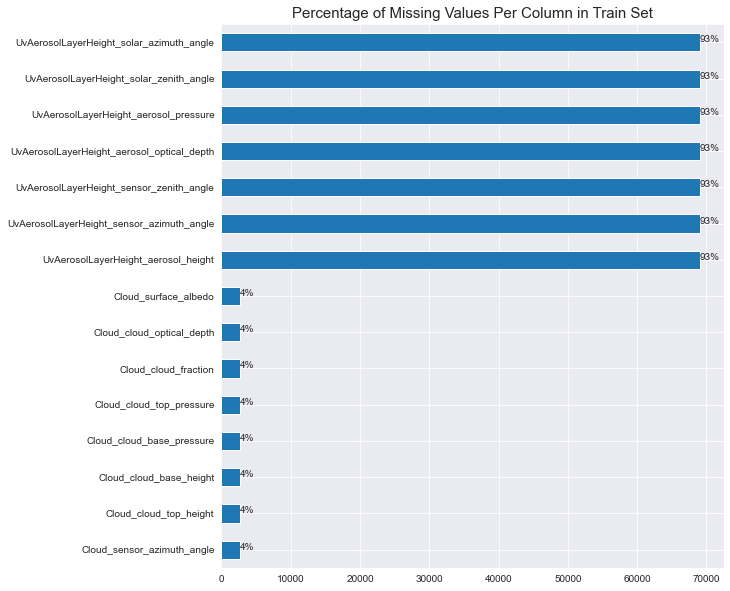

In [40]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [41]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(train)
X_imputed0 = imputer.transform(train)
X=pd.DataFrame(X_imputed0,columns=train.columns)

In [42]:
ID_test=test.ID_LAT_LON_YEAR_WEEK
test.drop(columns='ID_LAT_LON_YEAR_WEEK',inplace=True)

In [43]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(test)
X_imputed1 = imputer.transform(test)
test=pd.DataFrame(X_imputed1,columns=test.columns)

# Deleting highly correlated colmuns

In [44]:
X.shape

(74005, 75)

In [45]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95) ]

In [46]:
test.drop(columns=to_drop,inplace=True)
X.drop(columns=to_drop,inplace=True)

In [47]:
X.shape

(74005, 60)

# Target variable distribution

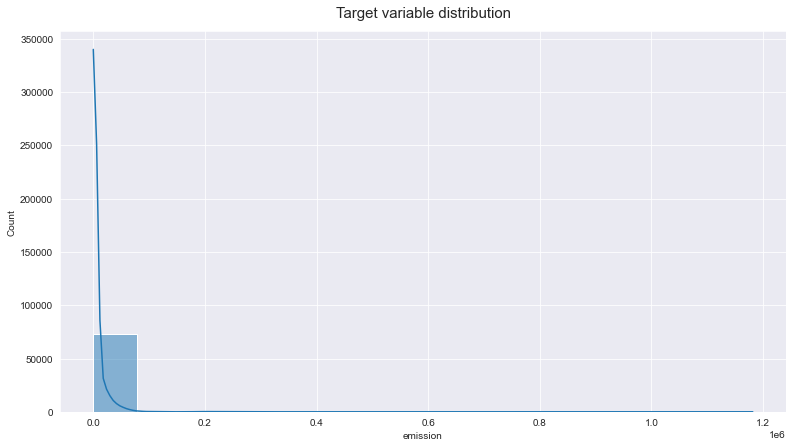

None

17.038027449698163

In [48]:
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(X.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), X.emission.skew())

In [49]:
max(X.emission)

1181701.2

In [50]:
X = X.drop(X[X['emission']>75000].index)

In [51]:
X.shape

(73398, 60)

# Feature Engineering

In [52]:
X['NO2_mean_perGroup']=1
grouped = X.groupby(['longitude'])
mean_x = grouped["NitrogenDioxide_NO2_column_number_density"].median()
X["NO2_mean_perGroup"] = X["longitude"].map(mean_x)

test['NO2_mean_perGroup']=1
grouped = test.groupby(['longitude'])
mean_y = grouped["NitrogenDioxide_NO2_column_number_density"].median()
test["NO2_mean_perGroup"] = test["longitude"].map(mean_y)

In [53]:
X['R']=np.sqrt(X['latitude']**2+(X['longitude']**2))
X['phi']=np.arctan(X['latitude'],X['longitude'])

In [54]:
test['R']=np.sqrt(test['latitude']**2+(test['longitude']**2))
test['phi']=np.arctan(test['latitude'],test['longitude'])

In [55]:
X.drop(columns=['latitude','longitude'],inplace=True)
test.drop(columns=['latitude','longitude'],inplace=True)

# Model

In [56]:
# Selecting the independent variables and the target variable
y = X.emission
X=X.drop(columns='emission')

In [57]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED,shuffle=True)

# Instantiating the model
#clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
#clf.fit(X_train, y_train)

# Create the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,learning_rate = 0.1,
                max_depth =2, n_estimators = 700,tree_method='gpu_hist',disable_default_eval_metric=1)

# Train the model on the training data
xg_reg.fit(X_train, y_train)

# Making predictions
y_pred = xg_reg.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 23432.342352754695

RMSE Score: 3150.968610947865


# Feature Selection

In [58]:
importances = xg_reg.feature_importances_
feature_names = X.columns

for idx, importance in enumerate(importances.argsort()[::-1]):
    print("{}. Feature: {}, Importance score: {:.2f}".format(
        idx+1, feature_names[importance], importances[importance]))
    if (importances[importance]==0):
        X.drop(columns=feature_names[importance],inplace=True)
        test.drop(columns=feature_names[importance],inplace=True)

1. Feature: NitrogenDioxide_NO2_column_number_density, Importance score: 0.16
2. Feature: NitrogenDioxide_NO2_slant_column_number_density, Importance score: 0.15
3. Feature: NO2_mean_perGroup, Importance score: 0.15
4. Feature: R, Importance score: 0.13
5. Feature: phi, Importance score: 0.06
6. Feature: Formaldehyde_sensor_zenith_angle, Importance score: 0.06
7. Feature: CarbonMonoxide_sensor_altitude, Importance score: 0.03
8. Feature: NitrogenDioxide_sensor_altitude, Importance score: 0.03
9. Feature: Cloud_surface_albedo, Importance score: 0.01
10. Feature: NitrogenDioxide_absorbing_aerosol_index, Importance score: 0.01
11. Feature: CarbonMonoxide_sensor_zenith_angle, Importance score: 0.01
12. Feature: NitrogenDioxide_cloud_fraction, Importance score: 0.01
13. Feature: UvAerosolIndex_absorbing_aerosol_index, Importance score: 0.01
14. Feature: Cloud_cloud_top_pressure, Importance score: 0.01
15. Feature: UvAerosolLayerHeight_aerosol_height, Importance score: 0.01
16. Feature: Sulp

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED,shuffle=True)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,learning_rate = 0.09,
                max_depth =2, n_estimators = 300,tree_method='gpu_hist',disable_default_eval_metric=1)

# Train the model on the training data
xg_reg.fit(X_train, y_train)

# Making predictions
y_pred = xg_reg.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE Score: 4162.292988511631


In [60]:
# Make prediction on the test set

predictions = xg_reg.predict(test)
# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': ID_test, 'emission': predictions})
sub_file.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,3167.29419
1,ID_-23.53_27.47_2019_2,3710.83179
2,ID_-23.53_27.47_2019_3,3740.11450
3,ID_-23.53_27.47_2019_4,3943.46411
4,ID_-23.53_27.47_2019_5,3730.07275


In [61]:
max(sub_file.emission)

36016.984375

In [62]:
# Create file
sub_file.to_csv('BaselineSubmission.csv', index = False)